## Setup

Load libraries:

In [3]:
import sys
sys.path.append('..')

In [ ]:
import srtm
import torch
import pickle
import rioxarray
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from snowmodels.utils import ConvertData
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from snowmodels.utils import compare_multiple_models
from snowmodels.density import SturmDensity, JonasDensity, PistochiDensity 

xgb_device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"XGBoost will run on {xgb_device}")

XGBoost will run on cuda


## Load Data

In [9]:
elevation_data = srtm.get_data()

In [2]:
maine_data=pd.read_csv('../data/Maine_Snow_Survey_Data.csv', low_memory=False)
maine_data.info()
maine_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48292 entries, 0 to 48291
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   X                 48292 non-null  float64
 1   Y                 48292 non-null  float64
 2   OBJECTID          48292 non-null  int64  
 3   SITE_ID           48292 non-null  int64  
 4   SITE_NAME         48292 non-null  object 
 5   MOVED_TO_SITE_ID  1684 non-null   float64
 6   SURVEY            29480 non-null  float64
 7   SURVEY_YEAR       48292 non-null  int64  
 8   SURVEY_DATE       46998 non-null  object 
 9   SURVEY_DATE_TEXT  48292 non-null  object 
 10  DEPTH             48292 non-null  float64
 11  WATER             48288 non-null  float64
 12  DENSITY           48288 non-null  float64
 13  CONFIDENCE_LEVEL  48292 non-null  object 
 14  SOURCE            48292 non-null  object 
 15  COMMENT           31309 non-null  object 
 16  ERROR             1900 non-null   object

,X,Y,OBJECTID,SITE_ID,SITE_NAME,MOVED_TO_SITE_ID,SURVEY,SURVEY_YEAR,SURVEY_DATE,SURVEY_DATE_TEXT,...,WATER,DENSITY,CONFIDENCE_LEVEL,SOURCE,COMMENT,ERROR,TRACE,LATITUDE,LONGITUDE,MGS_Key
0,689248.0000,4.758152e+06,1,1029,DIAMONDS (UWP),NaN,NaN,1903,1903/03/15 05:00:00+00,03/15/1903,...,7.80,0.24,UNKNOWN,NONE,,DATA FOR UNLOCATED SITE,NaN,42.952513,-66.680008,1
1,342400.8963,4.978854e+06,2,1028,AZISCOHOS/AZISCOHOS DAM (UWP),NaN,NaN,1906,1906/04/01 05:00:00+00,04/01/1906,...,2.40,0.34,UNKNOWN,NONE,,NaN,NaN,44.945659,-70.997712,2
2,331387.7661,4.961476e+06,3,1027,ERROL/ERROL DAM (UWP),NaN,NaN,1911,1911/03/01 05:00:00+00,03/01/1911,...,6.90,0.23,UNKNOWN,NONE,,NaN,NaN,44.786800,-71.131440,3
3,689248.0000,4.758152e+06,4,1139,RUMFORD (UWP),NaN,NaN,1911,1911/03/04 05:00:00+00,03/04/1911,...,3.75,0.47,UNKNOWN,NONE,,DATA FOR UNLOCATED SITE,NaN,42.952513,-66.680008,4
4,342400.8963,4.978854e+06,5,1028,AZISCOHOS/AZISCOHOS DAM (UWP),NaN,NaN,1911,1911/03/07 05:00:00+00,03/07/1911,...,6.50,0.24,UNKNOWN,NONE,,NaN,NaN,44.945659,-70.997712,5


In [11]:
snow_class_raster=rioxarray.open_rasterio('../data/SnowClass_NA_300m_10.0arcsec_2021_v01.0.nc')

In [ ]:
clean_df=(
    maine_data
    .query('CONFIDENCE_LEVEL == "GOOD" and DENSITY > 0 and DENSITY < 1')
    .filter(items=['SURVEY_DATE_TEXT' ,'DENSITY', 'WATER', 'DEPTH', 'LATITUDE', 'LONGITUDE'])
    .assign(
        Date=lambda x: pd.to_datetime(x.SURVEY_DATE_TEXT),
        Snow_Class=lambda x: x.loc[:, ["LONGITUDE", "LATITUDE"]].apply(lambda y: ConvertData.get_snow_class(lon=y.LONGITUDE, lat=y.LATITUDE, raster=snow_class_raster).capitalize(), axis=1),
        SWE=lambda x: ConvertData.inches_to_metric(inches=x.WATER, unit="cm"),
        Snow_Depth=lambda x: ConvertData.inches_to_metric(inches=x.DEPTH, unit="cm"),
        Snow_Density=lambda x: x.SWE / x.Snow_Depth,
        Sturm_DOWY=lambda x: x.Date.map(lambda y: ConvertData().date_to_DOY(y, algorithm="Sturm", origin=10)),
        Pistochi_DOWY=lambda x: x.Date.map(lambda y: ConvertData().date_to_DOY(y, algorithm="default", origin=11)),
        DOWY=lambda x: x.Date.map(lambda y: ConvertData().date_to_DOY(y, algorithm="default", origin=10)),
        Elevation= lambda x: x.loc[:, ["LONGITUDE", "LATITUDE"]].apply(lambda y: elevation_data.get_elevation(latitude=y.LATITUDE, longitude=y.LONGITUDE), axis=1)
    )
    .query('Snow_Class != "Ocean"')
    .dropna()
    .reset_index(drop=True)
    .drop(
        columns=[
            "SURVEY_DATE_TEXT",
            "WATER",
            "DEPTH",
            "LATITUDE",
            "LONGITUDE",
            "DENSITY"
        ]
    )
)
clean_df.info()
clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24235 entries, 0 to 24234
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           24235 non-null  datetime64[ns]
 1   Snow_Class     24235 non-null  object        
 2   SWE            24235 non-null  float64       
 3   Snow_Depth     24235 non-null  float64       
 4   Snow_Density   24235 non-null  float64       
 5   Sturm_DOWY     24235 non-null  float64       
 6   Pistochi_DOWY  24235 non-null  int64         
 7   DOWY           24235 non-null  int64         
 8   Elevation      24235 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 1.7+ MB


,Date,Snow_Class,SWE,Snow_Depth,Snow_Density,Sturm_DOWY,Pistochi_DOWY,DOWY,Elevation
0,1969-03-26,Alpine,18.288,58.42,0.313043,85.0,146,177,56.0
1,1969-03-26,Alpine,15.494,38.10,0.406667,85.0,146,177,94.0
2,1969-03-26,Ephemeral,14.224,38.10,0.373333,85.0,146,177,74.0
3,1969-03-26,Alpine,19.558,55.88,0.350000,85.0,146,177,69.0
4,1969-03-26,Ephemeral,15.240,35.56,0.428571,85.0,146,177,49.0


In [16]:
with open('../ML_weights/encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

# Use the loaded encoder
new_X_cat = loaded_encoder.transform(clean_df['Snow_Class'])
X_test_main = pd.concat([clean_df[['Elevation', 'Snow_Depth', 'DOWY']], new_X_cat], axis=1)

In [19]:
xgb_main = xgb.Booster()
xgb_main.load_model("../ML_weights/main_density_model.ubj")  # Load model from Uiversal Binary JSON file
xgb_main.set_param({"device": "cuda:1"})

In [20]:
density_results=(
    clean_df
    .assign(
        Observed_Density=clean_df.Snow_Density,
        Jonas_Density=lambda x: x.loc[:, ('Snow_Depth', 'Date', 'Elevation')].apply(lambda y: JonasDensity().compute_density(snow_depth=y.Snow_Depth*0.01, month=y.Date.month_name(), elevation= y.Elevation), axis=1),
        Pistochi_Density=lambda x: x.loc[:, 'Pistochi_DOWY'].apply(lambda y: PistochiDensity().compute_density(DOY=y)),
        Sturm_Density=lambda x: x.loc[:, ('Snow_Depth', 'Sturm_DOWY', 'Snow_Class')].apply(lambda y: SturmDensity().compute_density(snow_depth=y.Snow_Depth, DOY=y.Sturm_DOWY, snow_class= y.Snow_Class), axis=1),
        XGBoost_Density=xgb_main.predict(xgb.DMatrix(X_test_main)) 
    )
    # .query('Date > "2005-01-01"')
    .filter(items=['Observed_Density', 'Jonas_Density', 'Pistochi_Density', 'Sturm_Density', 'XGBoost_Density', 'SWE', 'Snow_Depth', 'Snow_Class'])
    .reset_index(drop=True)
)

density_results.head()

,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,XGBoost_Density,SWE,Snow_Depth,Snow_Class
0,0.313043,0.334753,0.407,0.345200,0.241787,18.288,58.42,Alpine
1,0.406667,0.334143,0.407,0.338973,0.298434,15.494,38.10,Alpine
2,0.373333,0.334143,0.407,NaN,0.378731,14.224,38.10,Ephemeral
3,0.350000,0.334676,0.407,0.344430,0.234743,19.558,55.88,Alpine
4,0.428571,0.334067,0.407,NaN,0.385895,15.240,35.56,Ephemeral


In [21]:
swe_results=(
    density_results
    .assign(
        Observed_SWE=density_results.SWE,
        Jonas_SWE=lambda x: x.Jonas_Density * x.Snow_Depth,
        Sturm_SWE=lambda x: x.Sturm_Density * x.Snow_Depth,
        Pistochi_SWE=lambda x: x.Pistochi_Density * x.Snow_Depth,
        XGBoost_SWE=lambda x: x.XGBoost_Density * x.Snow_Depth
    )
    .drop(
        columns=[
            'Observed_Density', 
            'Jonas_Density', 
            'Pistochi_Density', 
            'Sturm_Density', 
            'Snow_Depth',
            'XGBoost_Density',
            'SWE'
        ]
    )
)

swe_results.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
0,Alpine,18.288,19.556247,20.166613,23.77694,14.125168
1,Alpine,15.494,12.730848,12.914864,15.50670,11.370325
2,Ephemeral,14.224,12.730848,NaN,15.50670,14.429640
3,Alpine,19.558,18.701717,19.246766,22.74316,13.117459
4,Ephemeral,15.240,11.879415,NaN,14.47292,13.722439


In [23]:
compare_multiple_models(preds_df=swe_results.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
RMSE,4.497935,4.790041,7.432656,3.381312
MBE,2.492483,2.750972,5.617364,0.133310
RSQ,0.624994,0.574705,-0.024000,0.788075


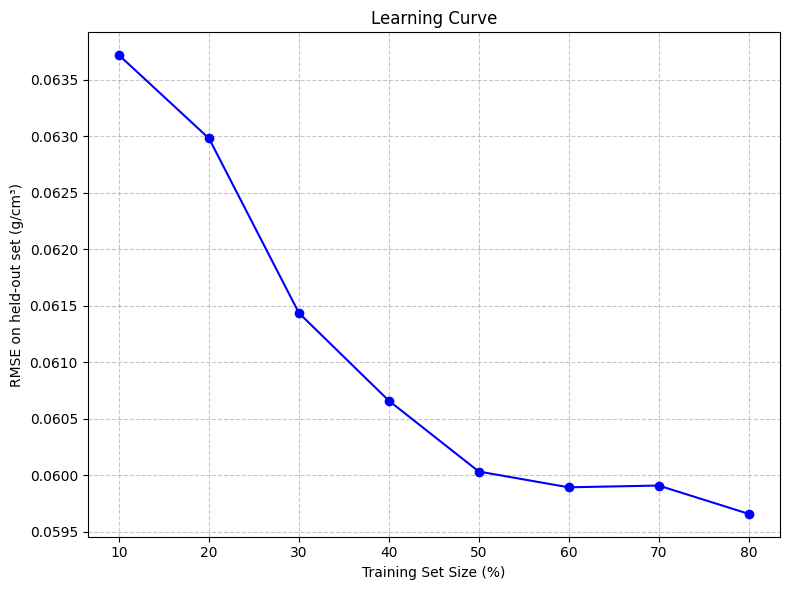

In [ ]:
def plot_learning_curve(X, y, xgb_params, random_state=42):
    """
    Plot a learning curve showing model performance (RMSE) with increasing training set sizes.
    
    Parameters:
    -----------
    X : array-like
        Features dataset
    y : array-like
        Target variable
    xgb_params : dict
        XGBoost parameters to use for model training
    random_state : int, default=42
        Random seed for reproducibility
    """
    # Make a copy of the parameters to avoid modifying the original
    model_params = xgb_params.copy()
    
    # First, set aside 20% of data as a fixed test set
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )
    
    # Define the percentages of the TRAINING data to use
    # These range from 12.5% to 100% of the training data (which is 80% of total data)
    # This will give us effective total percentages of 10%, 20%, 30%...80%
    train_subset_percentages = [12.5, 25, 37.5, 50, 62.5, 75, 87.5, 100]
    
    # Convert to percentages of total data for display
    train_size_percentages = [10, 20, 30, 40, 50, 60, 70, 80]
    
    # Calculate actual sample sizes based on the training set size
    n_train_full = len(X_train_full)
    sizes = [int(percentage / 100 * n_train_full) for percentage in train_subset_percentages]
    
    # For each size, we'll randomly sample from the full dataset
    # and split into train/test with the test size always being 20%
    rmse_values = []
    
    for size, percentage in zip(sizes, train_size_percentages):
        # For each size, we take a random subset of the full training data
        # These subsets get progressively larger
        
        # Get random indices from the full training set
        n_train_full = len(X_train_full)
        subset_size = min(size, n_train_full)  # Ensure we don't try to take more than available
        
        # Get random indices
        if isinstance(X_train_full, pd.DataFrame):
            # For pandas DataFrame
            indices = np.random.RandomState(random_state).choice(
                np.arange(n_train_full), size=subset_size, replace=False
            )
            idx_values = X_train_full.index[indices]
            X_subset = X_train_full.loc[idx_values]
            
            if isinstance(y_train_full, pd.DataFrame) or isinstance(y_train_full, pd.Series):
                if y_train_full.index.equals(X_train_full.index):
                    y_subset = y_train_full.loc[idx_values]
                else:
                    y_idx_values = y_train_full.index[indices]
                    y_subset = y_train_full.loc[y_idx_values]
            else:
                y_subset = y_train_full[indices]
        else:
            # For numpy arrays
            indices = np.random.RandomState(random_state).choice(
                n_train_full, size=subset_size, replace=False
            )
            X_subset = X_train_full[indices]
            y_subset = y_train_full[indices]
        
        
        dtrain = xgb.DMatrix(X_subset, label=y_subset)
        dtest = xgb.DMatrix(X_test)
        
        
        model = xgb.train(
            model_params,
            dtrain,
            num_boost_round=1498,
        )
        
       
        y_pred = model.predict(dtest)
        
        
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_values.append(rmse)
    
    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_size_percentages, rmse_values, 'o-', color='blue')
    plt.xlabel('Training Set Size (%)')
    plt.ylabel('RMSE on held-out set (g/cm³)')
    plt.title('Learning Curve')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return train_size_percentages, rmse_values, plt


xgb_params_from_optuna={
    'objective': 'reg:squarederror',
    'random_state': 42,
    'learning_rate': 0.012571635462866944,
    'gamma': 1.8331574770840668e-06,
    'min_child_weight': 12.338531236617445,
    'max_bin': 3350,
    'max_depth': 17,
    'subsample': 1,
    'device': xgb_device,  
    'tree_method': 'hist',
    'sampling_method': 'gradient_based'
}


sizes_percent, rmse_values, plt = plot_learning_curve(
    X_test_main, clean_df.Snow_Density, xgb_params=xgb_params_from_optuna
)
plt.show()

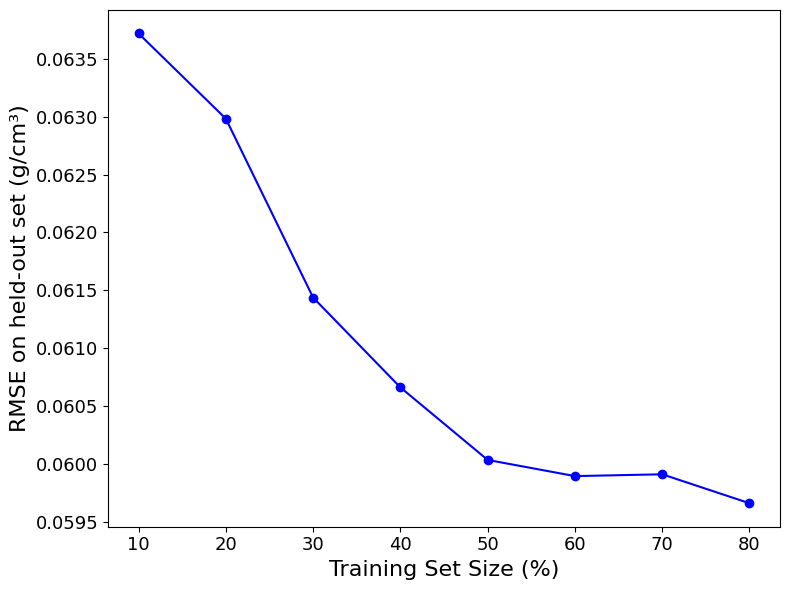

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(sizes_percent, rmse_values, 'o-', color='blue')
plt.xlabel('Training Set Size (%)', fontsize=16)
plt.ylabel('RMSE on held-out set (g/cm³)', fontsize=16)
plt.yticks(fontsize=13)
plt.xticks(sizes_percent, fontsize=13)
plt.tight_layout()
plt.savefig('../plots/figure11.jpg', dpi=300, bbox_inches='tight')
plt.show()

### Train with 10% Local Data 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X_test_main, clean_df.Snow_Density, test_size=0.9, random_state=42, stratify=clean_df.Snow_Class
)


train_data_full = xgb.DMatrix(X_train, label=y_train)

xgb_params_from_optuna={
    'objective': 'reg:squarederror',
    'random_state': 42,
    'learning_rate': 0.012571635462866944,
    'gamma': 1.8331574770840668e-06,
    'min_child_weight': 12.338531236617445,
    'max_bin': 3350,
    'max_depth': 17,
    'subsample': 1,
    'device': xgb_device,  
    'tree_method': 'hist',
    'sampling_method': 'gradient_based'
}
xgb_model = xgb.train(xgb_params_from_optuna, train_data_full, num_boost_round=1498) 
predictions_XGB = xgb_model.predict(xgb.DMatrix(X_test))

In [ ]:
density_results2=(
    clean_df.iloc[X_test.index]
    .assign(
        Observed_Density=y_test,
        Jonas_Density=lambda x: x.loc[:, ('Snow_Depth', 'Date', 'Elevation')].apply(lambda y: JonasDensity().compute_density(snow_depth=y.Snow_Depth*0.01, month=y.Date.month_name(), elevation= y.Elevation), axis=1),
        Pistochi_Density=lambda x: x.loc[:, 'Pistochi_DOWY'].apply(lambda y: PistochiDensity().compute_density(DOY=y)),
        Sturm_Density=lambda x: x.loc[:, ('Snow_Depth', 'Sturm_DOWY', 'Snow_Class')].apply(lambda y: SturmDensity().compute_density(snow_depth=y.Snow_Depth, DOY=y.Sturm_DOWY, snow_class= y.Snow_Class), axis=1),
        XGBoost_Density=predictions_XGB
    )
    .filter(items=['Observed_Density', 'Jonas_Density', 'Pistochi_Density', 'Sturm_Density', 'XGBoost_Density', 'SWE', 'Snow_Depth', 'Snow_Class'])
    .reset_index(drop=True)
)

density_results2.head()

,Observed_Density,Jonas_Density,Pistochi_Density,Sturm_Density,XGBoost_Density,SWE,Snow_Depth,Snow_Class
0,0.282609,0.334402,0.383,0.317206,0.255856,13.208,46.736,Alpine
1,0.304598,0.334326,0.389,0.322688,0.269420,13.462,44.196,Alpine
2,0.452941,0.282886,0.355,0.284406,0.187163,19.558,43.180,Alpine
3,0.265363,0.335728,0.406,0.353930,0.286673,24.130,90.932,Alpine
4,0.336842,0.334448,0.394,0.329172,0.295974,16.256,48.260,Alpine


In [82]:
swe_results2=(
    density_results2
    .assign(
        Observed_SWE=density_results2.SWE,
        Jonas_SWE=lambda x: x.Jonas_Density * x.Snow_Depth,
        Sturm_SWE=lambda x: x.Sturm_Density * x.Snow_Depth,
        Pistochi_SWE=lambda x: x.Pistochi_Density * x.Snow_Depth,
        XGBoost_SWE=lambda x: x.XGBoost_Density * x.Snow_Depth
    )
    .drop(
        columns=[
            'Observed_Density', 
            'Jonas_Density', 
            'Pistochi_Density', 
            'Sturm_Density', 
            'Snow_Depth',
            'XGBoost_Density',
            'SWE'
        ]
    )
)

swe_results2.head()

,Snow_Class,Observed_SWE,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
0,Alpine,13.208,15.628616,14.824957,17.899888,11.957668
1,Alpine,13.462,14.775867,14.261537,17.192244,11.907273
2,Alpine,19.558,12.215026,12.280632,15.328900,8.081715
3,Alpine,24.130,30.528415,32.183604,36.918392,26.067758
4,Alpine,16.256,16.140451,15.885856,19.014440,14.283707


In [83]:
compare_multiple_models(preds_df=swe_results2.dropna().drop(columns='Snow_Class'), y_true='Observed_SWE')

,Jonas_SWE,Sturm_SWE,Pistochi_SWE,XGBoost_SWE
RMSE,4.486743,4.776157,7.413676,2.766413
MBE,2.478377,2.734780,5.598891,-0.083550
RSQ,0.626328,0.576567,-0.020223,0.857943


## The End!